In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.preprocessing import FunctionTransformer, OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression

from sklearn.metrics import mean_squared_error, mean_squared_log_error

In [2]:
df = pd.read_csv('ToyotaCorolla.csv')
df.head()

,Price,Age,Kilometers,Fuel_Type,HP,Metallic,Color,Automatic,CC,Doors,Quarterly_Tax,Weight
0,13500,23,46986,Diesel,90,1,Blue,0,2000,3,210,1165
1,13750,23,72937,Diesel,90,1,Silver,0,2000,3,210,1165
2,13950,24,41711,Diesel,90,1,Blue,0,2000,3,210,1165
3,14950,26,48000,Diesel,90,0,Black,0,2000,3,210,1165
4,13750,30,38500,Diesel,90,0,Black,0,2000,3,210,1170


In [3]:
df.dtypes

Price             int64
Age               int64
Kilometers        int64
Fuel_Type        object
HP                int64
Metallic          int64
Color            object
Automatic         int64
CC                int64
Doors             int64
Quarterly_Tax     int64
Weight            int64
dtype: object

In [4]:
df['Metallic'].unique()

array([1, 0])

In [5]:
df['Automatic'].unique()

array([0, 1])

In [6]:
df['Metallic'] = df['Metallic'].astype(bool)
df['Automatic'] = df['Automatic'].astype(bool)

# 1. Trực quan hóa các thông tin thống kê mô tả cho các biến

In [7]:
cat_cols = ['Fuel_Type', 'Metallic', 'Color', 'Automatic']

In [8]:
df[cat_cols].describe()

,Fuel_Type,Metallic,Color,Automatic
count,1436,1436,1436,1436
unique,3,2,10,2
top,Petrol,True,Grey,False
freq,1264,969,301,1356


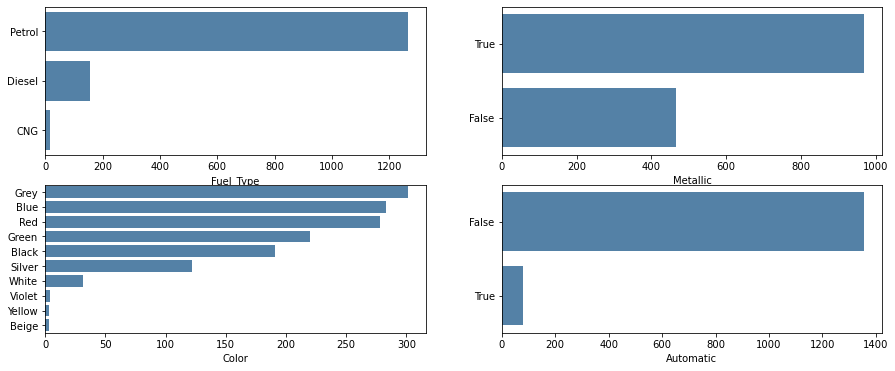

In [9]:
fig, axes = plt.subplots(2, 2, figsize=(15, 6))

for i, col in enumerate(cat_cols):
    value_counts = df[col].value_counts().sort_values(ascending=False)
    
    ax = axes[i//2][i%2]
    sns.barplot(x=value_counts, y=value_counts.index.astype(str),
                color='steelblue', ax=ax)

In [10]:
num_cols = df.select_dtypes(include='int64').columns

In [11]:
num_cols.size

8

In [12]:
melted = df[num_cols].melt()

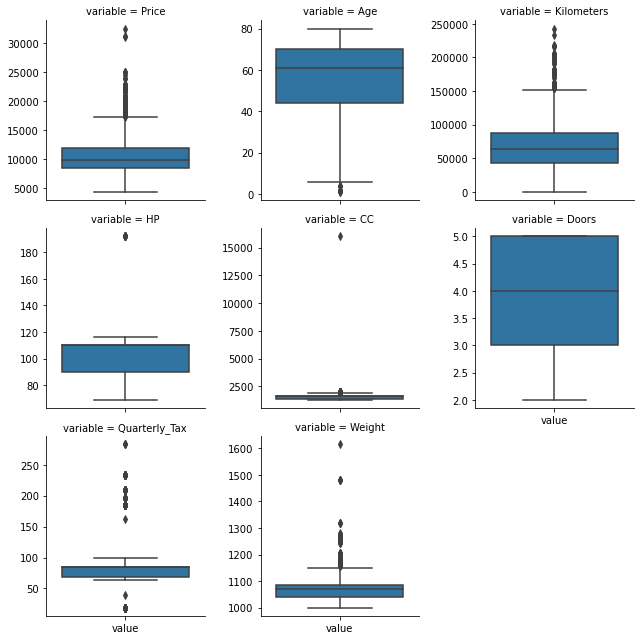

In [13]:
# sns.boxplot(data=df['Price'])
facet_grid = sns.FacetGrid(
    data=melted,
    col='variable',
    col_wrap=3,
    sharey=False,
)

facet_grid.map_dataframe(sns.boxplot)

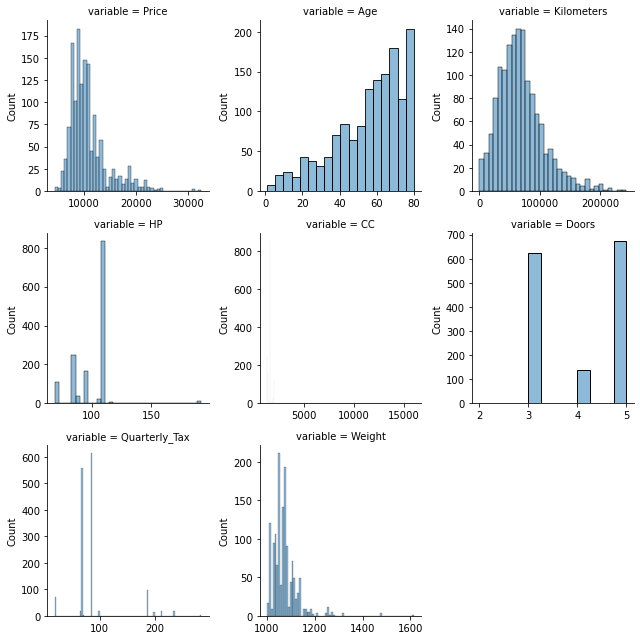

In [14]:
facet_grid = sns.FacetGrid(
    data=melted,
    col='variable',
    col_wrap=3,
    sharey=False,
    sharex=False,
)
facet_grid.map_dataframe(sns.histplot);

# 2. Tìm và trực quan mối quan hệ tương quan giữa các cặp biến (nếu có)

<AxesSubplot:>

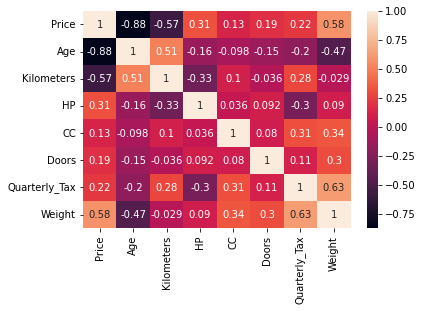

In [15]:
sns.heatmap(df[num_cols].corr(), annot=True)

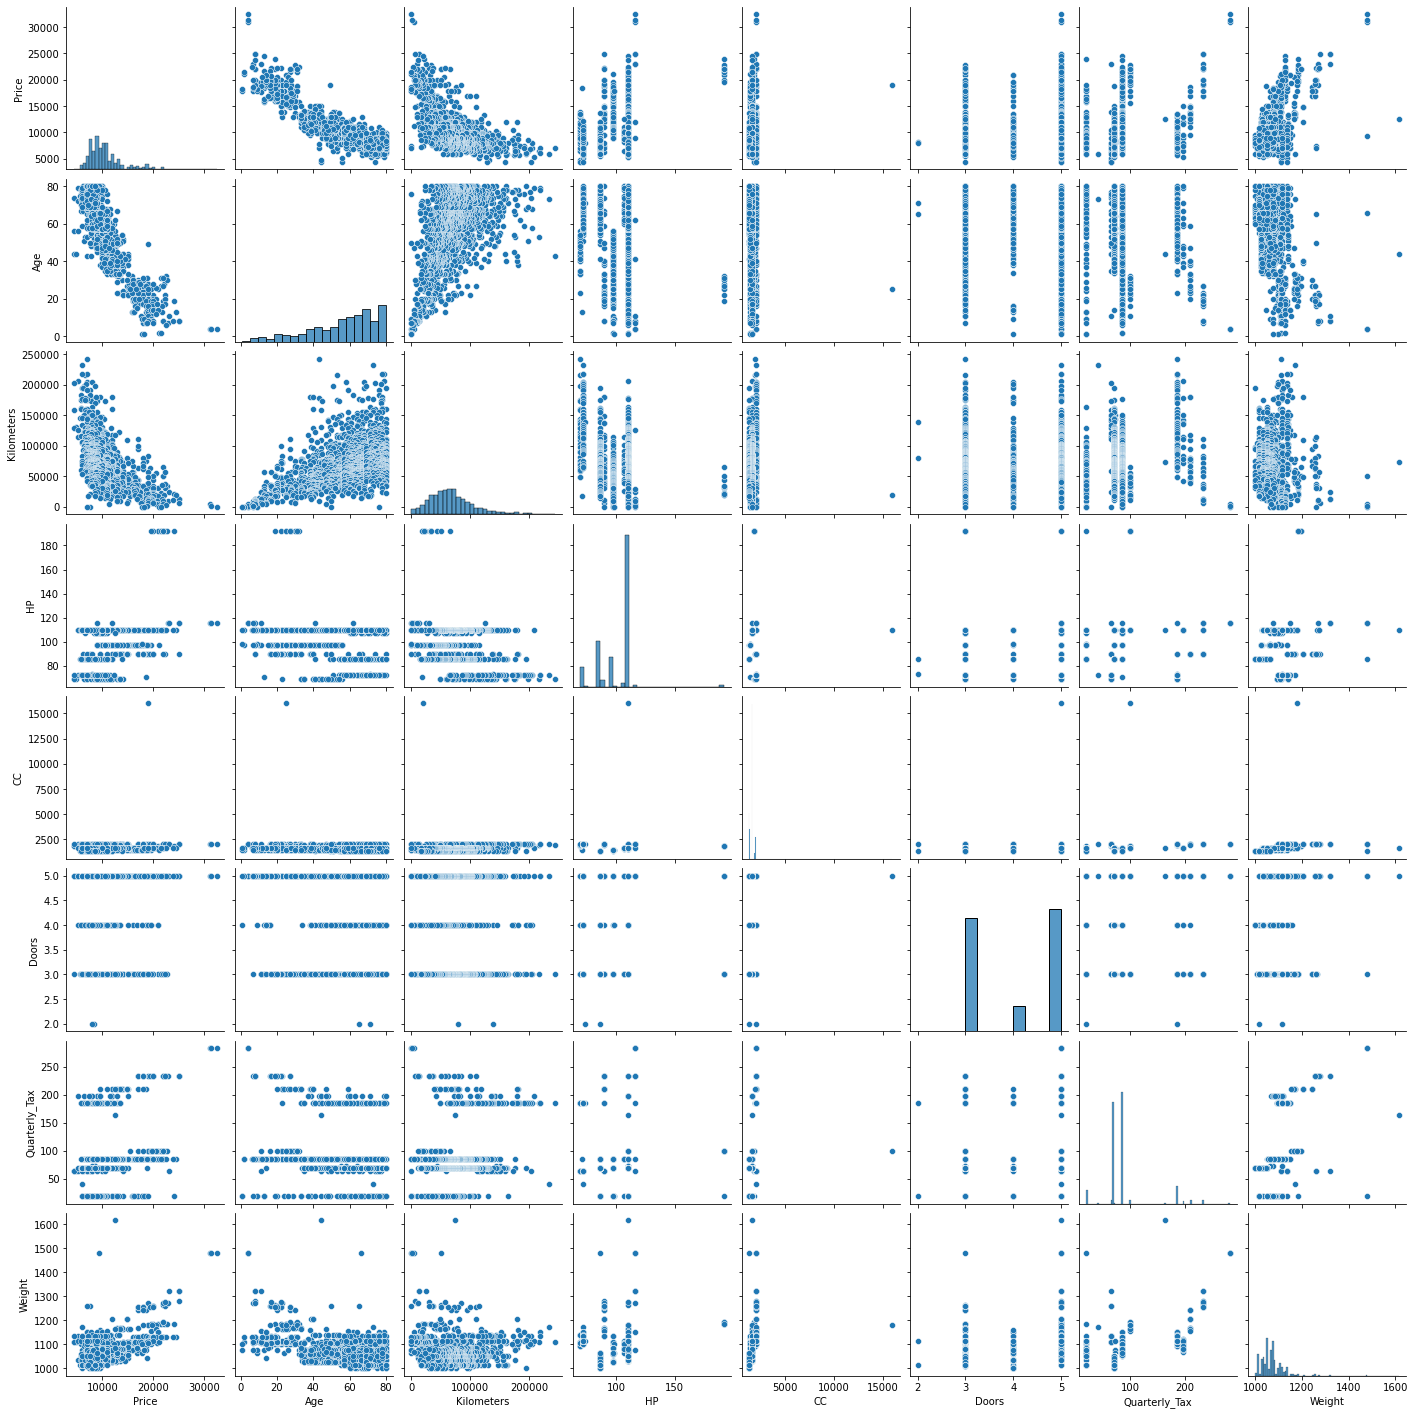

In [16]:
sns.pairplot(data=df[num_cols])

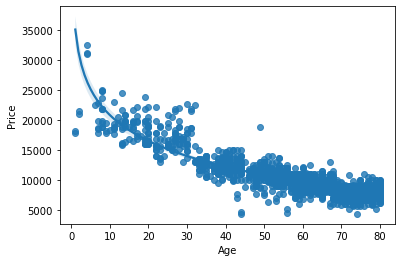

In [17]:
sns.regplot(data=df[['Price', 'Age']], x='Age', y='Price', logx=True);

<AxesSubplot:xlabel='Kilometers', ylabel='Price'>

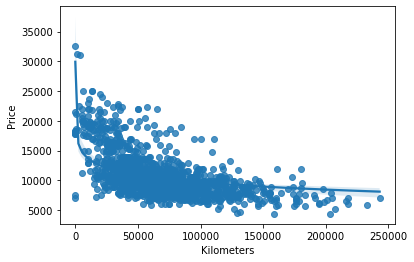

In [18]:
colors = df['Metallic'].apply(lambda x: '#91FF61' if x else '#BA61FF')

sns.regplot(data=df, x='Kilometers', y='Price', logx=True,)

<AxesSubplot:xlabel='Weight', ylabel='Price'>

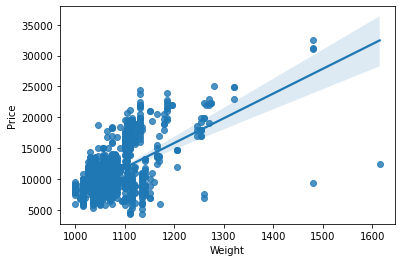

In [19]:
sns.regplot(x=df['Weight'], y=df['Price'])

<AxesSubplot:xlabel='Weight', ylabel='Age'>

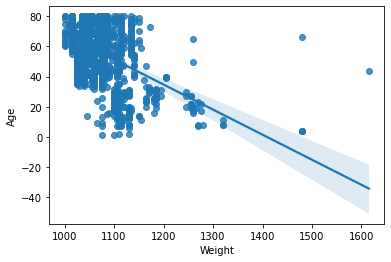

In [20]:
sns.regplot(data=df, x='Weight', y='Age')

# 3. Trực quan hóa biểu đồ histogram cho Price theo từng biến

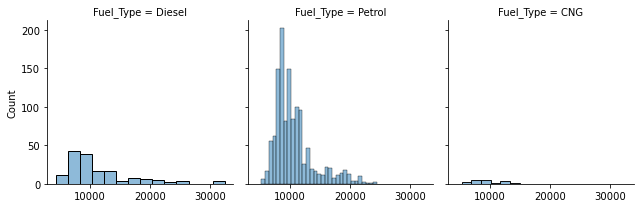

In [21]:
fg = sns.FacetGrid(
    data=df[['Fuel_Type', 'Price']],
    col='Fuel_Type',
)

fg.map_dataframe(sns.histplot)

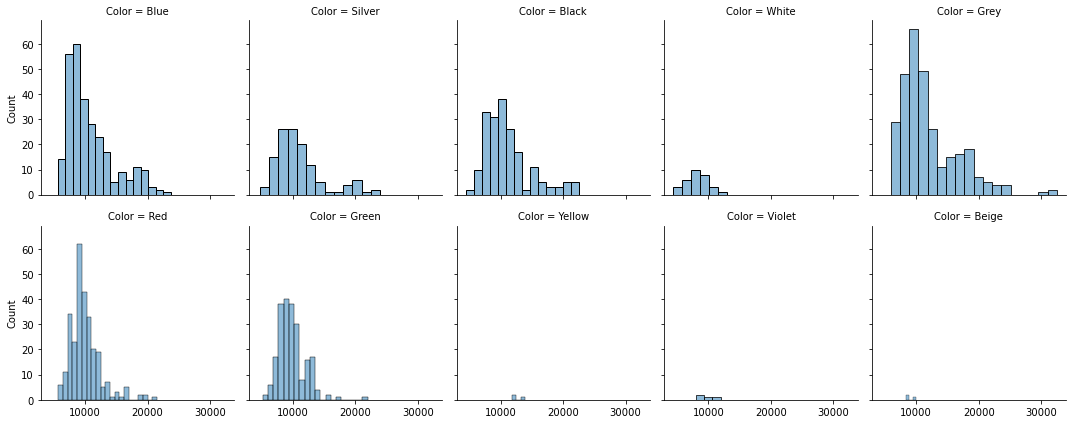

In [22]:
fg = sns.FacetGrid(
    data=df[['Color', 'Price']],
    col='Color',
    col_wrap=5,
)

fg.map_dataframe(sns.histplot)

# 4. Mô hình dự báo Price

In [23]:
y = df['Price'].copy()
X = df.drop(columns='Price').copy()

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [25]:
log_transformer = FunctionTransformer(func=np.log1p, validate=True)

In [26]:
num_cols

Index(['Price', 'Age', 'Kilometers', 'HP', 'CC', 'Doors', 'Quarterly_Tax',
       'Weight'],
      dtype='object')

In [27]:
column_transformer = ColumnTransformer(
    transformers=[
        ('onehot', OneHotEncoder(), cat_cols),
        ('log', log_transformer, ['Kilometers', 'Age']),
        ('scale', StandardScaler(), num_cols.drop(['Price', 'HP', 'CC'])),
    ]
)

In [28]:
model = Pipeline(
    steps=[
        ('preprocess', column_transformer),
        ('predict', LinearRegression())
    ],
)

In [29]:
model.fit(X_train, y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('onehot', OneHotEncoder(),
                                                  ['Fuel_Type', 'Metallic',
                                                   'Color', 'Automatic']),
                                                 ('log',
                                                  FunctionTransformer(func=<ufunc 'log1p'>,
                                                                      validate=True),
                                                  ['Kilometers', 'Age']),
                                                 ('scale', StandardScaler(),
                                                  Index(['Age', 'Kilometers', 'Doors', 'Quarterly_Tax', 'Weight'], dtype='object'))])),
                ('predict', LinearRegression())])

In [30]:
y_pred = model.predict(X_test)

In [31]:
mean_squared_error(y_test, y_pred)

1431572.5429263923

In [32]:
mean_squared_log_error(y_test, y_pred)

0.01240689636979207

<AxesSubplot:xlabel='Price'>

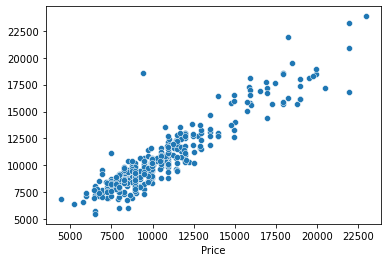

In [33]:
sns.scatterplot(x=y_test, y=y_pred)